# IDB_drilling_monitoring

## Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D

from keras import backend as K
from keras import metrics, optimizers, regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.layers import Input, Dense, Lambda, concatenate
from keras.losses import categorical_crossentropy, mean_squared_error
from keras.models import Model, load_model, Sequential, model_from_json

# fix random seed for reproducibility
tf.random.set_seed(123)
np.random.seed(123)

!nvidia-smi
HOST_path = "/root/autodl-tmp"
SAVE_path = os.path.join(HOST_path, "IDB_drilling_monitoring/cvae")

if not os.path.exists(SAVE_path):
    os.makedirs(SAVE_path)

2023-11-24 15:48:22.510638: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Fri Nov 24 15:48:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:32:00.0 Off |                  Off |
| 30%   27C    P8    18W / 450W |      2MiB / 24564MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load signal data

In [2]:
def load_table(table_path, time_start, time_end):
  SIGNAL_pd = pd.read_excel(table_path)
  # display(SIGNAL_pd)
  SIGNAL_arr = SIGNAL_pd.values[time_start-2+10 : time_end-2-10+1, 1:-1]
  print(type(SIGNAL_arr), SIGNAL_arr.shape, len(SIGNAL_arr)-1, "s")
  # print(SIGNAL_arr)
  return SIGNAL_arr

Y01A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 140, 325)
Y01B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 609, 791)
Y01C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 1115, 1305)
Y01D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 1530, 1733)

Y02A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 3795, 4021)
Y02B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 4241, 4461)
Y02C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 4649, 4877)
Y02D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 5100, 5337)

Y03A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 5780, 6059)
Y03B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 6267, 6500)
Y03C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 6760, 7005)
Y03D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-1.xls"), 7223, 7521)

Y04A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 123, 221)
Y04B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 463, 563)
Y04C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 773, 882)
Y04D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 1103, 1217)

Y05A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 1545, 1678)
Y05B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 1931, 2037)
Y05C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 2265, 2403)
Y05D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 2613, 2747)

Y06A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 3051, 3165)
Y06B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 3377, 3490)
Y06C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 3685, 3830)
Y06D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-2.xls"), 4169, 4287)

Y07A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 146, 439)
Y07B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 692, 929)
Y07C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 1129, 1389)
Y07D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 1592, 1837)

Y08A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 2316, 2567)
Y08B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 2809, 3058)
Y08C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 3431, 3677)
Y08D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 3895, 4157)

Y09A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 4437, 4705)
Y09B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 4951, 5229)
Y09C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 5869, 6178)
Y09D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 6396, 6675)

Y10A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 8285, 8415)
Y10B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 8629, 8800)
Y10C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 9087, 9285)
Y10D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 9710, 9911)

Y11A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 10370, 10580)
Y11B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 10785, 10975)
Y11C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 11144, 11332)
Y11D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 11733, 11967)

Y12A = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 12445, 12697)
Y12B = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 12955, 13146)
Y12C = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 13325, 13589)
Y12D = load_table(os.path.join(HOST_path, "IDB_drilling_monitoring/table/9.17-3+4.xls"), 13768, 14079)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (166, 8) 165 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (163, 8) 162 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (171, 8) 170 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (184, 8) 183 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (207, 8) 206 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (201, 8) 200 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (209, 8) 208 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (218, 8) 217 s
WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
<class 'numpy.ndarray'> (260, 8

In [3]:
table_list = ["Y01A", "Y01B", "Y01C", "Y01D",
         "Y02A", "Y02B", "Y02C", "Y02D",
         "Y03A", "Y03B", "Y03C", "Y03D",
         "Y04A", "Y04B", "Y04C", "Y04D",
         "Y05A", "Y05B", "Y05C", "Y05D",
         "Y06A", "Y06B", "Y06C", "Y06D",
         "Y07A", "Y07B", "Y07C", "Y07D",
         "Y08A", "Y08B", "Y08C", "Y08D",
         "Y09A", "Y09B", "Y09C", "Y09D",
         "Y10A", "Y10B", "Y10C", "Y10D",
         "Y11A", "Y11B", "Y11C", "Y11D",
         "Y12A", "Y12B", "Y12C", "Y12D"]

def check_table():
    for table in table_list:
        print(table, eval(table).shape, len(eval(table))-1,"s")
check_table()

Y01A (166, 8) 165 s
Y01B (163, 8) 162 s
Y01C (171, 8) 170 s
Y01D (184, 8) 183 s
Y02A (207, 8) 206 s
Y02B (201, 8) 200 s
Y02C (209, 8) 208 s
Y02D (218, 8) 217 s
Y03A (260, 8) 259 s
Y03B (214, 8) 213 s
Y03C (226, 8) 225 s
Y03D (279, 8) 278 s
Y04A (79, 8) 78 s
Y04B (81, 8) 80 s
Y04C (90, 8) 89 s
Y04D (95, 8) 94 s
Y05A (114, 8) 113 s
Y05B (87, 8) 86 s
Y05C (119, 8) 118 s
Y05D (115, 8) 114 s
Y06A (95, 8) 94 s
Y06B (94, 8) 93 s
Y06C (126, 8) 125 s
Y06D (99, 8) 98 s
Y07A (274, 8) 273 s
Y07B (218, 8) 217 s
Y07C (241, 8) 240 s
Y07D (226, 8) 225 s
Y08A (232, 8) 231 s
Y08B (230, 8) 229 s
Y08C (227, 8) 226 s
Y08D (243, 8) 242 s
Y09A (249, 8) 248 s
Y09B (259, 8) 258 s
Y09C (290, 8) 289 s
Y09D (260, 8) 259 s
Y10A (111, 8) 110 s
Y10B (152, 8) 151 s
Y10C (179, 8) 178 s
Y10D (182, 8) 181 s
Y11A (191, 8) 190 s
Y11B (171, 8) 170 s
Y11C (169, 8) 168 s
Y11D (215, 8) 214 s
Y12A (233, 8) 232 s
Y12B (172, 8) 171 s
Y12C (245, 8) 244 s
Y12D (292, 8) 291 s


## CVAE

### Data pretreatment

In [4]:
INDEX_dict = ["HEIGHT", "RPM", "TORQUE", "PUMPR", "PUMPP", "ROP", "WOB"]

In [5]:
X = np.concatenate((Y01A, Y01B, Y01C, Y01D,
                    Y02A, Y02B, Y02C, Y02D,
                    Y03A, Y03B, Y03C, Y03D,
                    Y04A, Y04B, Y04C, Y04D,
                    Y05A, Y05B, Y05C, Y05D,
                    Y06A, Y06B, Y06C, Y06D,
                    Y07A, Y07B, Y07C, Y07D,
                    Y08A, Y08B, Y08C, Y08D,
                    Y09A, Y09B, Y09C, Y09D,
                    Y10A, Y10B, Y10C, Y10D,
                    Y11A, Y11B, Y11C, Y11D,
                    Y12A, Y12B, Y12C, Y12D), axis=0)
print(type(X), X.shape)
print(X)

Y = X[:,[3,6]]
print(type(Y), Y.shape)
print(Y)

X = X[:,[2,4,5,7]]
print(type(X), X.shape)
print(X)

<class 'numpy.ndarray'> (8953, 8)
[['10:24:25' '-354.00' '233.00' ... '919.00' '29.00' '813.00']
 ['10:24:26' '-352.00' '295.00' ... '919.00' '26.00' '800.00']
 ['10:24:27' '-351.00' '306.00' ... '1312.00' '28.00' '800.00']
 ...
 ['22:06:22' '-245.00' '302.00' ... '611.00' '19.00' '915.00']
 ['22:06:23' '-245.00' '302.00' ... '609.00' '19.00' '915.00']
 ['22:06:24' '-245.00' '302.00' ... '608.00' '19.00' '915.00']]
<class 'numpy.ndarray'> (8953, 2)
[['90.48' '29.00']
 ['92.63' '26.00']
 ['92.95' '28.00']
 ...
 ['54.76' '19.00']
 ['53.67' '19.00']
 ['54.25' '19.00']]
<class 'numpy.ndarray'> (8953, 4)
[['233.00' '71.00' '919.00' '813.00']
 ['295.00' '71.00' '919.00' '800.00']
 ['306.00' '71.00' '1312.00' '800.00']
 ...
 ['302.00' '50.00' '611.00' '915.00']
 ['302.00' '50.00' '609.00' '915.00']
 ['302.00' '50.00' '608.00' '915.00']]


In [6]:
scaler_X = MinMaxScaler().fit(X)
scaler_Y = MinMaxScaler().fit(Y)
X = scaler_X.transform(X)  
Y = scaler_Y.transform(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [7]:
# np.save(os.path.join(SAVE_path, "X.npy"), X)
# np.save(os.path.join(SAVE_path, "Y.npy"), Y)
# np.save(os.path.join(SAVE_path, "X_train.npy"), X_train)
# np.save(os.path.join(SAVE_path, "X_test.npy"), X_test)
# np.save(os.path.join(SAVE_path, "Y_train.npy"), Y_train)
# np.save(os.path.join(SAVE_path, "Y_test.npy"), Y_test)

### Model establishment

In [8]:
n_x = X.shape[1]
n_y = Y.shape[1]
n_z = 2

In [9]:
VALUE = Input(shape=(n_x,))
LABEL = Input(shape=(n_y,))

In [10]:
inputs = concatenate([VALUE, LABEL])

In [11]:
encoder_1l = Dense(512, activation='relu')(inputs)
encoder_2l = Dense(256, activation='relu')(encoder_1l)
encoder_3l = Dense(128, activation='relu')(encoder_2l)

2023-11-24 15:48:39.001486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-24 15:48:39.553518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22128 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:32:00.0, compute capability: 8.9


In [12]:
mu = Dense(n_z)(encoder_3l)
l_sigma = Dense(n_z)(encoder_3l)

In [13]:
def sample_z(args):
    mu, l_sigma = args
    epsilon = K.random_normal(shape=(K.shape(mu)[0], n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * epsilon

In [14]:
z = Lambda(sample_z, output_shape=(n_z,))([mu, l_sigma])
z_cond = concatenate([z, LABEL])

In [15]:
decoder_1 = Dense(128, activation='relu') 
decoder_2 = Dense(256, activation='relu')
decoder_3 = Dense(512, activation='relu')
decoder_r = Dense(n_x, activation='sigmoid')

In [16]:
decoder_1l = decoder_1(z_cond)
decoder_2l = decoder_2(decoder_1l)
decoder_3l = decoder_3(decoder_2l)

In [17]:
outputs = decoder_r(decoder_3l)

In [18]:
CVAE = Model([VALUE, LABEL], outputs)

ENCODER = Model([VALUE, LABEL], z)

d_input = Input(shape=(n_z,))
d_input_cond = concatenate([d_input, LABEL])
d_1l = decoder_1(d_input_cond)
d_2l = decoder_2(d_1l)
d_3l = decoder_3(d_2l)
d_output = decoder_r(d_3l)
DECODER = Model([d_input, LABEL], d_output)

In [19]:
# def cvae_loss(y_true, y_pred):
#     re_loss = mean_squared_error(y_true, y_pred)
#     kl_loss = - 0.5 * K.mean(1 + l_sigma - K.square(mu) - K.exp(l_sigma), axis=-1)
#     return re_loss + kl_loss

re_loss = mean_squared_error(K.flatten(VALUE), K.flatten(outputs))
kl_loss = 1 + l_sigma - K.square(mu) - K.exp(l_sigma)
kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
cvae_loss = K.mean(re_loss + kl_loss)
CVAE.add_loss(cvae_loss)
CVAE.compile(optimizer='rmsprop')
CVAE.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 4)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 6)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 512)          3584        ['concatenate[0][0]']        

### Model training

In [20]:
callbacks = [
             ModelCheckpoint(os.path.join(SAVE_path, "cvae_model_best.hdf5"),
                             monitor="val_loss",
                             mode="min",
                             verbose=1,
                             save_best_only=True),
             # EarlyStopping(monitor="val_loss",
             #               mode="min",
             #               verbose=1,
             #               patience=5,
             #               restore_best_weights=True),
            ]

history = CVAE.fit([X_train, Y_train], X_train,
                   epochs=100,
                   batch_size=10,
                   shuffle=True,
                   callbacks = callbacks,
                   validation_data=([X_test, Y_test], X_test),
                  )

Epoch 1/100
 24/717 [>.............................] - ETA: 4s - loss: 0.0424 

2023-11-24 15:48:41.871885: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


710/717 [============================>.] - ETA: 0s - loss: 0.0236
Epoch 1: val_loss improved from inf to 0.01965, saving model to /root/autodl-tmp/IDB_drilling_monitoring/cvae/cvae_model_best.hdf5
717/717 [==============================] - 7s 7ms/step - loss: 0.0236 - val_loss: 0.0197
Epoch 2/100
715/717 [============================>.] - ETA: 0s - loss: 0.0154
Epoch 2: val_loss improved from 0.01965 to 0.01964, saving model to /root/autodl-tmp/IDB_drilling_monitoring/cvae/cvae_model_best.hdf5
717/717 [==============================] - 6s 8ms/step - loss: 0.0154 - val_loss: 0.0196
Epoch 3/100
712/717 [============================>.] - ETA: 0s - loss: 0.0123
Epoch 3: val_loss improved from 0.01964 to 0.01322, saving model to /root/autodl-tmp/IDB_drilling_monitoring/cvae/cvae_model_best.hdf5
717/717 [==============================] - 5s 7ms/step - loss: 0.0123 - val_loss: 0.0132
Epoch 4/100
714/717 [============================>.] - ETA: 0s - loss: 0.0112
Epoch 4: val_loss improved from 

In [21]:
CVAE.save(os.path.join(SAVE_path, "cvae_model.hdf5"))
ENCODER.save(os.path.join(SAVE_path, "encoder_model.hdf5"))
DECODER.save(os.path.join(SAVE_path, "decoder_model.hdf5"))
np.save(os.path.join(SAVE_path, "cvae_history.npy"), history.history)

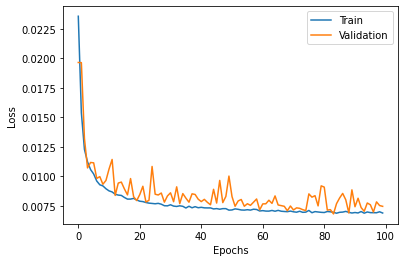

In [22]:
plt.plot(CVAE.history.history['loss'])
plt.plot(CVAE.history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train','Validation'],loc='upper right')
plt.savefig(os.path.join(SAVE_path, "cvae_loss.png"), dpi=300, bbox_inches='tight', transparent=True)

### Latent space

In [23]:
Y_test_real = scaler_Y.inverse_transform(Y_test)

180/180 [==============================] - 0s 1ms/step


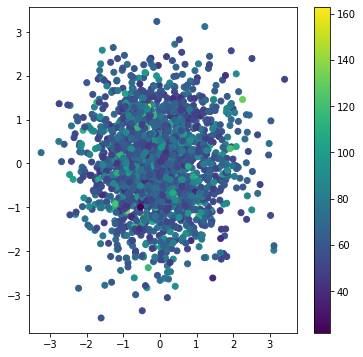

In [24]:
X_test_encoded = ENCODER.predict([X_test, Y_test], batch_size=10)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test_real[:,0])
plt.colorbar()
plt.savefig(os.path.join(SAVE_path, "latent_space_0.png"), dpi=300, bbox_inches='tight', transparent=True)

180/180 [==============================] - 0s 2ms/step


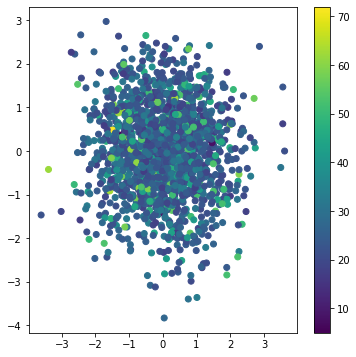

In [25]:
X_test_encoded = ENCODER.predict([X_test, Y_test], batch_size=10)
plt.figure(figsize=(6, 6))
plt.scatter(X_test_encoded[:, 0], X_test_encoded[:, 1], c=Y_test_real[:,1])
plt.colorbar()
plt.savefig(os.path.join(SAVE_path, "latent_space_1.png"), dpi=300, bbox_inches='tight', transparent=True)

### Generating data

In [26]:
num_of_samples = 10000

In [27]:
np.random.seed(42)

In [28]:
Y_sampling = np.random.uniform(0, 1, (num_of_samples, 2))
print(Y_sampling.shape)
print(Y_sampling[:20])
np.save(os.path.join(SAVE_path, "Y_sampling.npy"), Y_sampling)
np.savetxt(os.path.join(SAVE_path, "Y_sampling.csv"), Y_sampling, delimiter=', ', fmt='%f')

(10000, 2)
[[0.37454012 0.95071431]
 [0.73199394 0.59865848]
 [0.15601864 0.15599452]
 [0.05808361 0.86617615]
 [0.60111501 0.70807258]
 [0.02058449 0.96990985]
 [0.83244264 0.21233911]
 [0.18182497 0.18340451]
 [0.30424224 0.52475643]
 [0.43194502 0.29122914]
 [0.61185289 0.13949386]
 [0.29214465 0.36636184]
 [0.45606998 0.78517596]
 [0.19967378 0.51423444]
 [0.59241457 0.04645041]
 [0.60754485 0.17052412]
 [0.06505159 0.94888554]
 [0.96563203 0.80839735]
 [0.30461377 0.09767211]
 [0.68423303 0.44015249]]


In [29]:
Y_sampling_real = scaler_Y.inverse_transform(Y_sampling)
print(Y_sampling_real.shape)
print(Y_sampling_real[:20])
np.save(os.path.join(SAVE_path, "Y_sampling_real.npy"), Y_sampling_real)
np.savetxt(os.path.join(SAVE_path, "Y_sampling_real.csv"), Y_sampling_real, delimiter=', ', fmt='%f')

(10000, 2)
[[ 75.80755931  82.95857313]
 [127.25588804  54.0899957 ]
 [ 44.35576292  17.79155067]
 [ 30.2599743   76.02644395]
 [108.41848364  63.06195138]
 [ 24.86272626  84.53260788]
 [141.71346929  22.41180708]
 [ 48.07006753  20.03916981]
 [ 65.68958603  48.03002739]
 [ 84.06984653  28.8807895 ]
 [109.96398714  16.43849657]
 [ 63.94837926  35.04167115]
 [ 87.54215283  69.38442883]
 [ 50.63904747  47.16722395]
 [107.1662289    8.80893384]
 [109.34393053  18.98297814]
 [ 31.26287578  82.80861405]
 [160.88341852  71.28858255]
 [ 65.7430598   13.00911335]
 [120.38165951  41.09250449]]


In [30]:
mean = [0,0]
cov = [[1, 0], [0, 1]]

In [31]:
np.random.seed(42)

In [32]:
Z_sampling = np.random.multivariate_normal(mean, cov, num_of_samples)
print(Z_sampling.shape)
print(Z_sampling)
np.save(os.path.join(SAVE_path, "Z_sampling.npy"), Z_sampling)
np.savetxt(os.path.join(SAVE_path, "Z_sampling.csv"), Z_sampling, delimiter=', ', fmt='%f')

(10000, 2)
[[ 0.49671415 -0.1382643 ]
 [ 0.64768854  1.52302986]
 [-0.23415337 -0.23413696]
 ...
 [ 0.95259051  0.38782734]
 [ 1.37736658  0.37835397]
 [ 1.71352973 -1.6199198 ]]


In [33]:
samples_scaled = DECODER.predict([Z_sampling, Y_sampling])
print(samples_scaled.shape)
print(samples_scaled)

generated_samples = scaler_X.inverse_transform(samples_scaled)
print(generated_samples.shape)
print(generated_samples)
np.save(os.path.join(SAVE_path, "generated_samples.npy"), generated_samples)
np.savetxt(os.path.join(SAVE_path, "generated_samples.csv"), generated_samples, delimiter=', ', fmt='%f')

313/313 [==============================] - 0s 1ms/step
(10000, 4)
[[0.86103886 0.7881538  0.5667508  0.5898881 ]
 [0.5992758  0.6463248  0.4034613  0.6414831 ]
 [0.03790224 0.7781202  0.61920464 0.6561036 ]
 ...
 [0.9341624  0.893605   0.7302389  0.51203257]
 [0.32596543 0.57214063 0.23534994 0.02539311]
 [0.03176623 0.7742019  0.51828796 0.66481024]]
(10000, 4)
[[ 410.98178    60.831383  838.0053    829.8039  ]
 [ 345.01752    54.02359   633.7301    887.95154 ]
 [ 203.55136    60.34977   903.625     904.4288  ]
 ...
 [ 429.40894    65.893036 1042.5289    742.0607  ]
 [ 276.14328    50.462753  423.4228    193.61803 ]
 [ 202.00508    60.161694  777.37823   914.24115 ]]


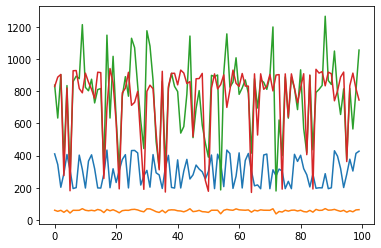

In [34]:
plt.plot(generated_samples[0:100,0])
plt.plot(generated_samples[0:100,1])
plt.plot(generated_samples[0:100,2])
plt.plot(generated_samples[0:100,3])
plt.savefig(os.path.join(SAVE_path, "generated_distribution.png"), dpi=300, bbox_inches='tight', transparent=True)